In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import numpy as np

import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [4]:
gold = pd.read_csv('/content/gold_price_data.csv')
gold['Date'] = pd.to_datetime(gold['Date'], errors='coerce')
gold

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [5]:
gold.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


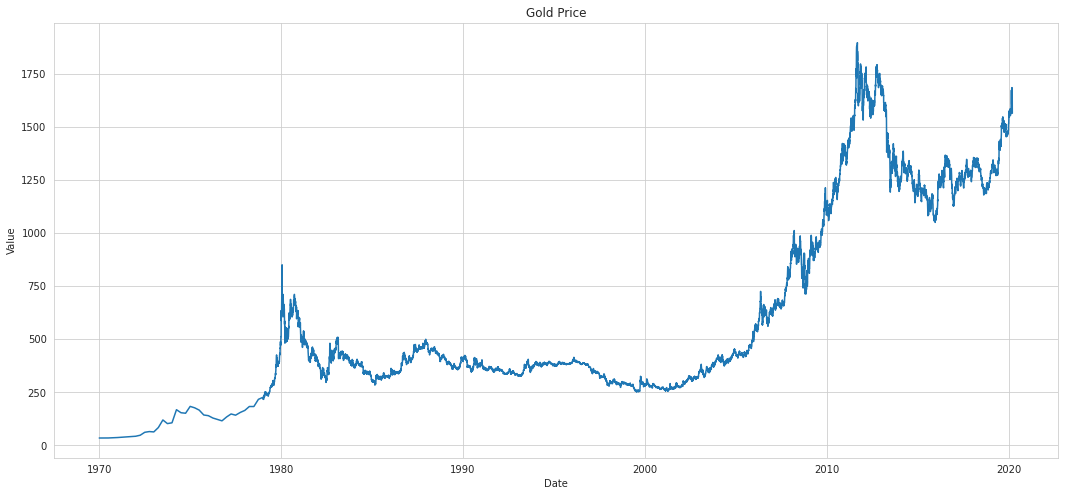

In [6]:
plt.figure(figsize = (18,8))
sns.lineplot(data=gold, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

Time Series Components (Level, Trend, Seasonality)

In [7]:
gold_eda = gold.copy()
gold_eda.set_index('Date', inplace=True)

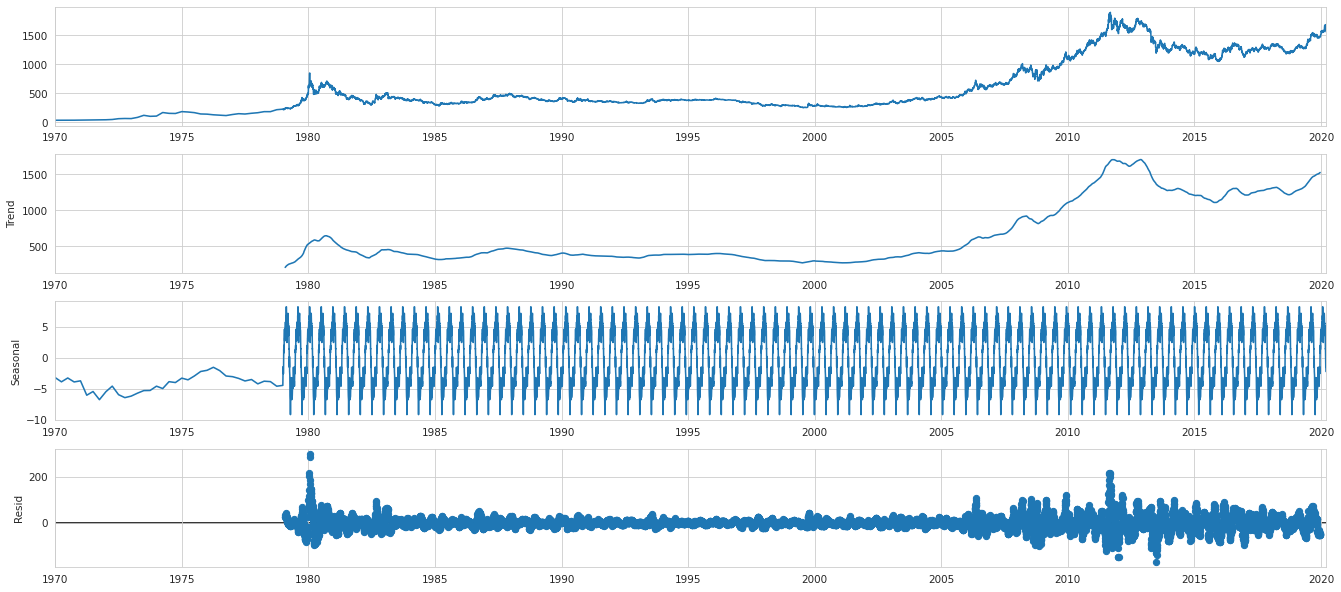

In [8]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_eda, model='additive', period=120)
result.plot()
plt.show()

Data Splitting

I decide to split data into 75:*25*

In [9]:
X_train = gold[:8090]
X_test = gold[8090:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (8090, 2)
X_test Shape (2697, 2)


Forecasting For Nine Months Ahead

In [10]:
X_train = X_train[['Date', 'Value']]
X_test = X_test[['Date', 'Value']]

X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)

In [11]:
index_9_months = pd.date_range(X_test.index[-1], freq='MS', periods=9)
index_9_months

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

Define d Using ADF Test

d= The difference is taken d times until the original series becomes stationary.


In [12]:
def define_d(data):
    X_train = adfuller(data, autolag='AIC')
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]['5%']
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'Critical Value']
    for value,label in zip(X_train,labels):
        print(label+' : '+str(value) )

    if (pvalue < 0.05):
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")

define_d(X_train)

ADF Test Statistic : 0.7111393941300074
p-value : 0.9900575735401028
#Lags Used : 36
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Indicating It Is Non-Stationary **


In [13]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -15.695627256339975
p-value : 1.416302779850631e-28
#Lags Used : 35
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Data Is Stationary **


q=A moving average model uses a regression-like model on past forecast errors. 


p=the number of autoregressive terms
d= is the number of nonseasonal differences needed for stationarity
q= is the number of lagged forecast errors in the prediction equation

Dedfine p and q using PACF and ACF

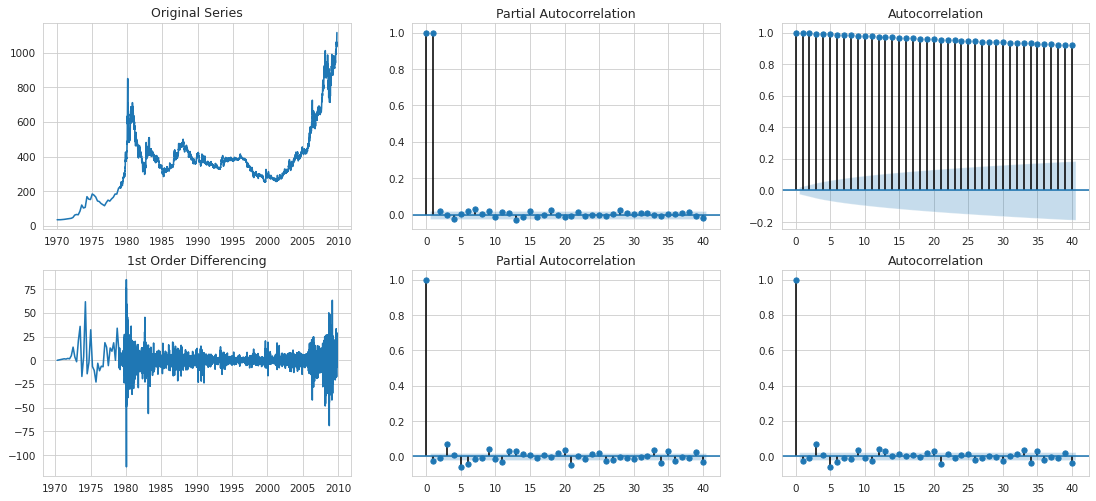

In [14]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(X_train); axes[0, 0].set_title('Original Series')
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show()

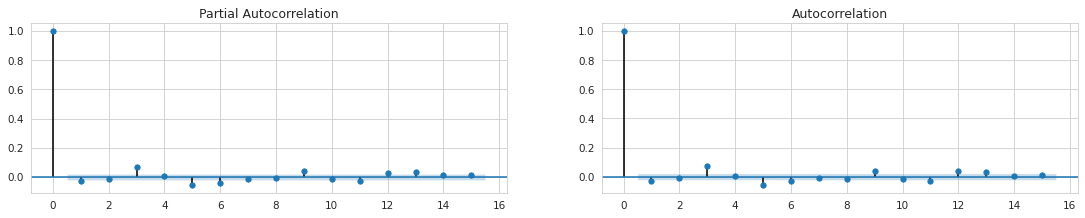

In [15]:
plt.rcParams.update({'figure.figsize':(18,3), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
plot_pacf(X_train.diff().dropna(), lags = 15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags = 15, ax=ax[1])
plt.show()

In [16]:
gold_validate = gold['Value'][8090:]

Model 1


In [17]:
model_gold = ARIMA(X_train, order = (0, 1, 0))
gold_010 = model_gold.fit(disp=0)
print(gold_010.summary())

fc, se, conf = gold_010.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -26954.488
Method:                           css   S.D. of innovations              6.775
Date:                Mon, 06 Feb 2023   AIC                          53912.977
Time:                        17:54:17   BIC                          53926.973
Sample:                             1   HQIC                         53917.765
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1335      0.075      1.772      0.076      -0.014       0.281


{'Mean Absolute Percentage Error (%)': 12.26,
 'Root Mean Squared Error': 233.47932977267214}

Model 2

In [18]:
model_gold = ARIMA(X_train, order = (1, 1, 1))
gold_111 = model_gold.fit(disp=0)
print(gold_111.summary())

fc, se, conf = gold_111.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26951.423
Method:                       css-mle   S.D. of innovations              6.773
Date:                Mon, 06 Feb 2023   AIC                          53910.847
Time:                        17:54:19   BIC                          53938.840
Sample:                             1   HQIC                         53920.423
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1335      0.073      1.825      0.068      -0.010       0.277
ar.L1.D.Value     0.0448      0.165      0.271      0.786      -0.279       0.368
ma.L1.D.Value    -0.0723      0.164     

{'Mean Absolute Percentage Error (%)': 12.25,
 'Root Mean Squared Error': 233.55868267268346}

Model 3

In [19]:
model_gold = ARIMA(X_train, order = (1, 1, 0))
gold_110 = model_gold.fit(disp=0)
print(gold_110.summary())

fc, se, conf = gold_110.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -26951.520
Method:                       css-mle   S.D. of innovations              6.773
Date:                Mon, 06 Feb 2023   AIC                          53909.040
Time:                        17:54:19   BIC                          53930.034
Sample:                             1   HQIC                         53916.222
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1335      0.073      1.820      0.069      -0.010       0.277
ar.L1.D.Value    -0.0271      0.011     -2.437      0.015      -0.049      -0.005
                                    Root

{'Mean Absolute Percentage Error (%)': 12.25,
 'Root Mean Squared Error': 233.55400735215355}

Model 4

In [20]:
model_gold = ARIMA(X_train, order = (0, 1, 1))
gold_011 = model_gold.fit(disp=0)
print(gold_011.summary())

fc, se, conf = gold_011.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -26951.461
Method:                       css-mle   S.D. of innovations              6.773
Date:                Mon, 06 Feb 2023   AIC                          53908.921
Time:                        17:54:19   BIC                          53929.916
Sample:                             1   HQIC                         53916.103
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1335      0.073      1.823      0.068      -0.010       0.277
ma.L1.D.Value    -0.0276      0.011     -2.467      0.014      -0.049      -0.006
                                    Root

{'Mean Absolute Percentage Error (%)': 12.25,
 'Root Mean Squared Error': 233.55609965419615}

Using the best order(p,d,q) on the basis of MSE


In [21]:
p_values= range(0,8)
d_values = range(0,3)
q_values =range(0,5)

In [ ]:
for p in p_values:
  for d in d_values:
    for q in q_values:
      order =(p,d,q)
      predictions=list()
      for i in range(len(X_test)):
        try:
           model = ARIMA(X_train,order)
           model_fit=model.fit(disp=0)
           pred_y = model_fit.forecast()[0]#to select first column
           predictions.append(pred_y)
           error= mean_squared_error(X_test,predictions)
           print("ARIMA%s MSE=%.2f" %(order,error))
        except:
             continue

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
#automation of testing: just enter the datasheet name and know weather it is 
#stationary or not.
def adf_test(dataset):
  import pandas as pd
  import matplotlib.pyplot as plt
  %matplotlib inline
  ds = pd.read_csv(dataset, index_col=[0], parse_dates=[0],nrows=365, squeeze=True)
  print(ds.hist())
  ds_split= int(len(ds)/2)
  ds1 = ds[0:ds_split]
  ds2 = ds[ds_split:]
  print('mean 1-',ds1.mean())
  print('mean 2-',ds2.mean())
  print('var 1-',ds1.var())
  print('var 2-',ds1.var())
  from statsmodels.tsa.stattools import adfuller
  adf_test =adfuller(ds)
  print('Adfuller stats-',adf_test[0])
  print('p values-',adf_test[1])



In [ ]:
adf_test('gold_price_data.csv')

In [ ]:
Gold_model= ARIMA(X_train, order=(1,1,1))

In [ ]:
Gold_model_fit= Gold_model.fit(disp=0)

In [ ]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
residuals = pd.DataFrame(Gold_model_fit.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

gold_011.plot_predict(dynamic=False)
plt.title('Comparison Forecast Test', fontsize = 12)
plt.show()

Forecasting

In [ ]:
gold_forecast = Gold_model_fit.forecast(9)[0]
gold_forecast = pd.Series(gold_forecast, index=index_9_months)
gold_forecast = gold_forecast.rename("Prediction")

fig, ax = plt.subplots(figsize = (18, 9))
sns.lineplot(x = 'Date', y='Value', data=gold, color = 'blue', marker = '^')
gold_forecast.plot(ax = ax, c = 'red', marker = 'x', label = 'Prediction')
X_test.plot(ax = ax, c = 'blue', marker = '^')
plt.title('Gold Price')
ax.axvline(x = 18370, ls = ':', linewidth = 3, c = 'green', label = 'Border')
plt.legend(loc = 0, fontsize = 15)
plt.show()
